# 1 The objective of this notebook is to analyze the data from the dataset and set up a reference metric with a baseline mode

## Data Atributes/Description:

Attributes:
 * id : unique identifier for candidate (numeric)

 * job_title : job title for candidate (text)

 * location : geographical location for candidate (text)

 * connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
 * fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”





In [58]:
#---------Importing libraries---------#

#---Data analysis---#
import pandas as pd
import numpy as np


#---Data visualization---#
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


#---NLP---#
import re
import string
from collections import Counter

import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#---nltkDownloads---# https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#from sentence_transformers import SentenceTransformer


#---utils---#
import os
from pathlib import Path


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\joaot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joaot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\joaot\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\joaot\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\joaot\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-d

In [8]:
#spacy
#lemmatization with spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm')

## Step 1: Data Loading and Inspection

Load the dataset into a pandas DataFrame.

Check the dimensions of the dataset (number of rows and columns).

Examine the first few rows of the dataset to get an initial understanding of the data.

Check for any missing values in the dataset.

In [9]:
raw_data_path = os.path.join(os.path.pardir, 'data', 'raw', 'potential-talents - Aspiring human resources - seeking human resources.csv')

df = pd.read_csv(raw_data_path)

df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [10]:
df.dtypes

id              int64
job_title      object
location       object
connection     object
fit           float64
dtype: object

In [11]:
#onyl object cols
df[df.columns[df.dtypes == 'object']].describe()

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


In [12]:
df.describe(include=object)

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


In [13]:
#checking for missing values
df.isnull().sum()

id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64

## Step 2: Data Cleaning and Preprocessing

Handle missing values, if any, by either imputing them or removing rows/columns with missing values, depending on the situation.

Convert categorical variables into appropriate data types (e.g., convert 'month' and 'contact' to categorical data type).

Encode binary categorical variables ('default', 'housing', 'loan', and 'y') into numeric format (0 and 1) for modeling purposes.

In [14]:
# drop the fit row
df.drop(columns=['fit'], inplace=True)

df.head()

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


In [15]:
#setting the index to be the id
df.set_index('id', inplace=True)

In [16]:
#checking for duplicated rows
df.duplicated().sum()

51

In [17]:
#drop duplicated rows
df.drop_duplicates(inplace=True)
df.shape

(53, 3)

In [18]:
#checking for na or null values
df.isnull().sum()

job_title     0
location      0
connection    0
dtype: int64

In [19]:
df_clean = df.copy()


# Text Preprocessing

Col - job tittles

In [20]:
#text preprocessing function
def text_cleaner(text):
    #lowercase
    text = text.lower() #not required in BERT
    #remove special characters and digits
    text = re.sub(r"(\d|\W)+"," ", text) 
    #remove single characters from the start, from the middle and from the end of the text
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)#not required in BERT
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)#not required in BERT
    text = re.sub(r'\s+[a-zA-Z]$', ' ', text)#not required in BERT
    #removing numbers
    text = re.sub(r'\d+', '', text)#not required in BERT

    #remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    text_tokens = nltk.word_tokenize(text)
    text = [word for word in text_tokens if word not in stop_words]
    
    #lemmatization with spacy
    text = nlp(' '.join(text))
    text = [word.lemma_ for word in text] #not required in BERT
    text = ' '.join(text)
    #remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    



    return text

## cleaning time!

In [21]:
df_clean['job_title'] = df_clean['job_title'].apply(lambda x: text_cleaner(x))
df_clean['location'] = df_clean['location'].apply(lambda x: text_cleaner(x))
df_clean['connection'] = df['connection'].str.replace(r'\+', '', regex=True)
df_clean.head(15)

,job_title,location,connection
id,,,
1,bauer college business graduate magna cum laud...,houston texas,85
2,native english teacher epik english program korea,kanada,500
3,aspire human resource professional,raleigh durham north carolina area,44
4,people development coordinator ryan,denton texas,500
5,advisory board member celal bayar university,zmir türkiye,500
6,aspire human resource specialist,great new york city area,1
7,student humber college aspire human resource g...,kanada,61
8,hr senior specialist,san francisco bay area,500
10,seek human resource hris generalist position,great philadelphia area,500


In [22]:
# Creating an extra column with all columns combined
df_clean['all_text'] = df_clean['job_title'] + ' ' + \
    df_clean['location'] + ' ' + df_clean['connection'] 

df_clean.head()

,job_title,location,connection,all_text
id,,,,
1,bauer college business graduate magna cum laud...,houston texas,85,bauer college business graduate magna cum laud...
2,native english teacher epik english program korea,kanada,500,native english teacher epik english program ko...
3,aspire human resource professional,raleigh durham north carolina area,44,aspire human resource professional raleigh dur...
4,people development coordinator ryan,denton texas,500,people development coordinator ryan denton tex...
5,advisory board member celal bayar university,zmir türkiye,500,advisory board member celal bayar university z...


In [23]:
#example:
df_clean['all_text'].iloc[0]

'bauer college business graduate magna cum laude aspire human resource professional houston texas 85'

In [24]:
# visualizing the differences that cleaning made
print(df_clean['job_title'].iloc[0])
print(df['job_title'].iloc[0])

bauer college business graduate magna cum laude aspire human resource professional
2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional


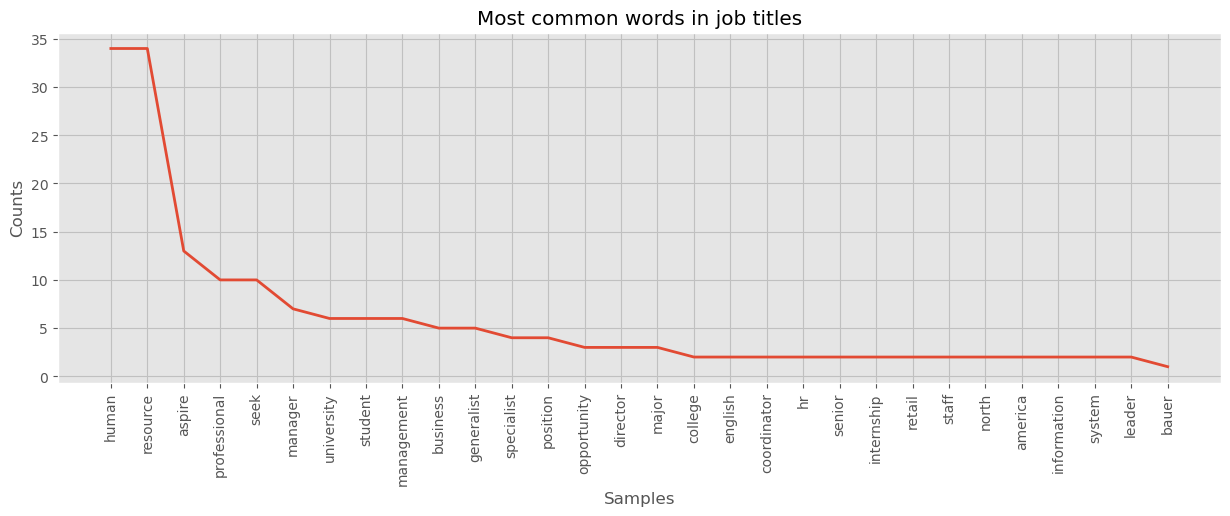

In [25]:
#most commum words in job tittle and in all text

fig = plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
words = list(df_clean['job_title'].values)
words = ' '.join(words).split()
FreqDist = nltk.FreqDist(words)
plt.title('Most common words in job titles')
FreqDist.plot(30, cumulative=False);


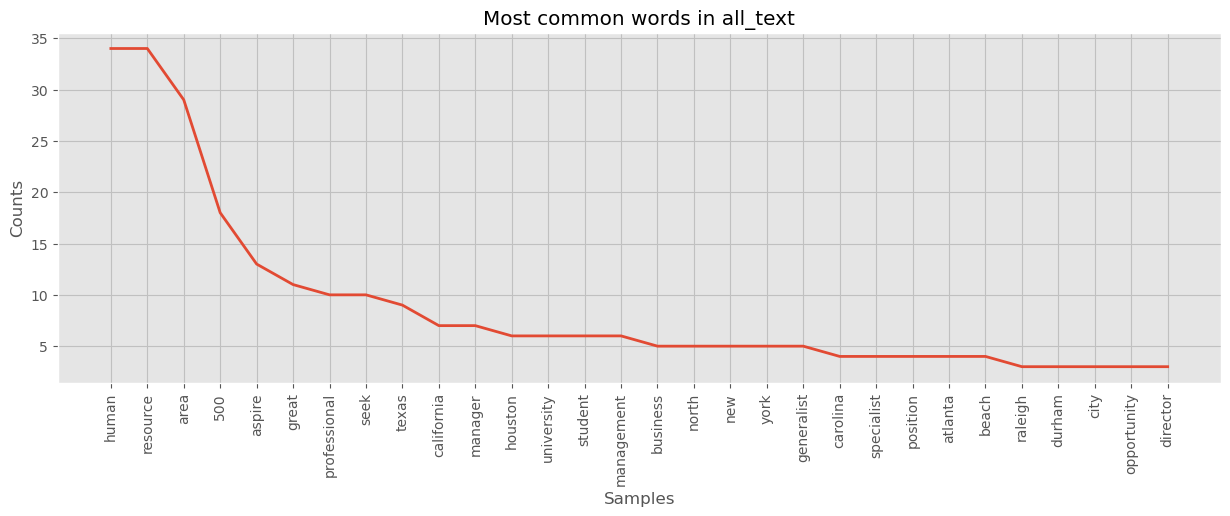

In [26]:
#most commum words in job tittle and in all_text

fig = plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
words = list(df_clean['all_text'].values)
words = ' '.join(words).split()
FreqDist = nltk.FreqDist(words)
plt.title('Most common words in all_text')
FreqDist.plot(30, cumulative=False);

## Vector representation of job titles, location and connections ( per row), cossine similarity on key phrases

In [27]:
#vectorizing the all_text cols to further perform similarity analysis
# on Keywords: “Aspiring human resources” or “seeking human resources”
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_clean['job_title'])
print(vectorizer.get_feature_names_out())




['administration' 'administrative' 'admission' 'advisory' 'always'
 'america' 'analyst' 'analytic' 'army' 'art' 'aspire' 'assistant'
 'atlanta' 'bachelor' 'bauer' 'bayar' 'beach' 'benefit' 'beneteau'
 'biology' 'board' 'brand' 'buckhead' 'business' 'care' 'celal' 'center'
 'chapman' 'chro' 'college' 'communication' 'community' 'compensation'
 'conflict' 'coordinator' 'create' 'csr' 'cum' 'customer' 'datum' 'delphi'
 'development' 'director' 'employment' 'endemol' 'energetic' 'energy'
 'engage' 'engie' 'engineer' 'english' 'entry' 'environment'
 'environmental' 'epik' 'excellence' 'executive' 'experience' 'ey' 'focus'
 'generalist' 'gis' 'gphr' 'graduate' 'graduating' 'groupe' 'guard'
 'hardware' 'heil' 'helping' 'houston' 'hr' 'hris' 'human' 'humber'
 'illinois' 'inc' 'inclusive' 'indiana' 'information' 'intelligence'
 'intercontinental' 'international' 'internship' 'japan' 'jti' 'junior'
 'kokomo' 'korea' 'lab' 'laude' 'lead' 'leader' 'level' 'liberal' 'log'
 'long' 'loparex' 'louis' 

In [28]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [50]:
key_sents = ['aspiring human resources', 'seeking human resources']
#split the keywords into tokens, unique and lemmatized with set and spacy

keywords = sorted(set([word.lemma_ for word in nlp(' '.join(key_sents))]))
keywords



['aspire', 'human', 'resource', 'seek']

In [52]:
type(nlp(' '.join(key_sents)))


spacy.tokens.doc.Doc

In [63]:
#cosine similarity of the all_text embbedings vs keywords  “Aspiring human resources” or “seeking human resources”


def add_similarity_col(df, keywords):
    #vectorizing/embedding the all_text cols to further perform similarity analysis, using the model passed form parameter
    #create an instance of tfidfVectorizer
    tfvectorizer = TfidfVectorizer()
    X = tfvectorizer.fit_transform(df['job_title'].tolist())
    key_df = pd.DataFrame(X.toarray(), columns=X.get_feature_names())
    shape = key_df.shape
    #calculate the cosine similarity between the keyword and the data's rows
    cosine_sim = cosine_similarity(key_tf.toarray()[:shape[0]-1], key_tf.toarray()[shape[0]-1].reshape(1, -1))
    #Add cosine resluts into a new column fit
    df['fit_tfidf']=cosine_sim
    #store the ranked candidates based on the fit score
    final_df=df.sort_values('fit_tfidf',ascending=False)
    #remove the keyword added to reuse the function again on other different keywords
    corpus.pop()
    return final_df








In [64]:
final_df=add_similarity_col(df_clean, keywords)

AttributeError: 'csr_matrix' object has no attribute 'get_feature_names'

# 

## Roberta Pretrained Model

* transformer model accounts for the words but also the context of the words in the sentence

In [ ]:
#getting the embeddings of the col all_text with BERT

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

#tokenizing the all_text col
tokenized = df_clean['all_text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

#padding the tokenized col
max_len = 0
for i in tokenized.values: